
Biweekly Trends in Anxiety and Depression Prevalence

Perinatal-relevant demographic groups (Female and ages 18–49)

Clean Time-Series Analysis (Female & Age 18–49)

Household Pulse Survey (2020–2024)


## 0. Imports

In [86]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


## 1. Load Dataset

In [87]:
from pathlib import Path

# CSV placed next to this notebook
FILE_PATH = Path("Indicators_of_Anxiety_or_Depression_Based_on_Reported_Frequency_of_Symptoms_During_Last_7_Days.csv")

df = pd.read_csv(FILE_PATH)
df.head()

,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,Confidence Interval,Quartile Range
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,23.5,22.7,24.3,22.7 - 24.3,NaN
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,32.7,30.2,35.2,30.2 - 35.2,NaN
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,25.7,24.1,27.3,24.1 - 27.3,NaN
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,24.8,23.3,26.2,23.3 - 26.2,NaN
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,23.2,21.5,25.0,21.5 - 25.0,NaN


In [88]:
# 1. Standardize the Date column
df['Time Period Start Date'] = pd.to_datetime(df['Time Period Start Date'])

# 2. Filter for your target demographic (Example: Anxiety symptoms in Females)
female_df = df[(df['Group'] == 'By Sex') & (df['Subgroup'] == 'Female')]

# 3. Create the 'female_ts' variable by resampling to a 2-week frequency
female_ts = female_df.sort_values('Time Period Start Date').set_index('Time Period Start Date')['Value']
female_ts = female_ts.resample('2W').mean().interpolate(method='linear')

# 4. Create the 'age_ts' dictionary for your age cohorts
age_groups = ['18 - 29 years', '30 - 39 years', '40 - 49 years']
age_ts = {}
for age in age_groups:
    ts = df[(df['Group'] == 'By Age') & (df['Subgroup'] == age)].sort_values('Time Period Start Date').set_index('Time Period Start Date')['Value']
    age_ts[age] = ts.resample('2W').mean().interpolate(method='linear')

In [103]:

# STATIONARITY TESTING (ADF TEST)

from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series, name):
    print(f"--- Statistical Test for: {name} ---")
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    
    if result[1] <= 0.05:
        print("Conclusion: The data is Stationary. (Directly ready for modeling)")
    else:
        print("Conclusion: The data is Non-Stationary. (Will require differencing 'd=1' in SARIMA)")
    print("-" * 40)


perform_adf_test(female_ts, "Female (Childbearing Age Proxy)")
for age_label, series in age_ts.items():
    perform_adf_test(series, f"Age Group: {age_label}")

--- Statistical Test for: Female (Childbearing Age Proxy) ---
ADF Statistic: -0.5478
p-value: 0.8823
Conclusion: The data is Non-Stationary. (Will require differencing 'd=1' in SARIMA)
----------------------------------------
--- Statistical Test for: Age Group: 18 - 29 years ---
ADF Statistic: -1.1179
p-value: 0.7079
Conclusion: The data is Non-Stationary. (Will require differencing 'd=1' in SARIMA)
----------------------------------------
--- Statistical Test for: Age Group: 30 - 39 years ---
ADF Statistic: -0.7416
p-value: 0.8357
Conclusion: The data is Non-Stationary. (Will require differencing 'd=1' in SARIMA)
----------------------------------------
--- Statistical Test for: Age Group: 40 - 49 years ---
ADF Statistic: -0.9081
p-value: 0.7853
Conclusion: The data is Non-Stationary. (Will require differencing 'd=1' in SARIMA)
----------------------------------------


In [90]:

# Stationarity Diagnostics (ADF Test)


from statsmodels.tsa.stattools import adfuller

def adf_test(series, label):
    series = series.dropna()
    result = adfuller(series, autolag="AIC")
    output = {
        "Group": label,
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Lags Used": result[2],
        "N Observations": result[3]
    }
    return output

adf_rows = []
adf_rows.append(adf_test(female_ts, "Female"))

for band, ts in age_ts.items():
    adf_rows.append(adf_test(ts, band))

adf_df = pd.DataFrame(adf_rows)
adf_df


,Group,ADF Statistic,p-value,Lags Used,N Observations
0,Female,-0.547842,0.882338,4,109
1,18 - 29 years,-1.117864,0.707896,2,111
2,30 - 39 years,-0.741588,0.835681,4,109
3,40 - 49 years,-0.908108,0.785291,1,112


interpretation: p-value < 0.05 ⇒ likely stationary; otherwise non-stationary (common in health prevalence series). Even if non-stationary, SARIMA with differencing is justified.

Stationarity Verification (The After Test)

In [107]:
from statsmodels.tsa.stattools import adfuller

def check_after_differencing(series, name):
    # Apply first-order differencing (d=1) to verify stationarity
    diff_series = series.diff().dropna()
    result = adfuller(diff_series)
    
    print(f"--- ADF Test AFTER Differencing: {name} ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("Result: Stationary (Success - The 'I' in SARIMA is valid)")
    else:
        print("Result: Still Non-Stationary")
    print("-" * 30)

# Run the check for all groups
check_after_differencing(female_ts, "Female Proxy")
for band in AGE_GROUPS:
    check_after_differencing(age_ts[band], band)
    # ADF Test AFTER Differencing

from statsmodels.tsa.stattools import adfuller

def adf_test_differenced(series, label):
    # Apply first-order differencing
    diff_series = series.diff().dropna()
    result = adfuller(diff_series, autolag="AIC")
    output = {
        "Group": label,
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Lags Used": result[2],
        "N Observations": result[3]
    }
    return output

adf_rows_diff = []
adf_rows_diff.append(adf_test_differenced(female_ts, "Female"))

for band, ts in age_ts.items():
    adf_rows_diff.append(adf_test_differenced(ts, band))

adf_df_diff = pd.DataFrame(adf_rows_diff)
adf_df_diff

--- ADF Test AFTER Differencing: Female Proxy ---
ADF Statistic: -5.5802
p-value: 0.0000
Result: Stationary (Success - The 'I' in SARIMA is valid)
------------------------------
--- ADF Test AFTER Differencing: 18 - 29 years ---
ADF Statistic: -8.0118
p-value: 0.0000
Result: Stationary (Success - The 'I' in SARIMA is valid)
------------------------------
--- ADF Test AFTER Differencing: 30 - 39 years ---
ADF Statistic: -7.7656
p-value: 0.0000
Result: Stationary (Success - The 'I' in SARIMA is valid)
------------------------------
--- ADF Test AFTER Differencing: 40 - 49 years ---
ADF Statistic: -7.2552
p-value: 0.0000
Result: Stationary (Success - The 'I' in SARIMA is valid)
------------------------------


,Group,ADF Statistic,p-value,Lags Used,N Observations
0,Female,-5.580228,1.402070e-06,3,109
1,18 - 29 years,-8.011846,2.190721e-12,1,111
2,30 - 39 years,-7.765571,9.207780e-12,0,112
3,40 - 49 years,-7.255241,1.737753e-10,0,112


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_performance_metrics(series, name):
    # Re-run a fit to get 'fittedvalues' for historical comparison
    model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,26),
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    
    actual = series
    predicted = results.fittedvalues
    
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    
    return {"Group": name, "Model": "SARIMA", "RMSE": rmse, "MAE": mae}


performance_list = []
performance_list.append(get_performance_metrics(female_ts, "Female"))
for band in AGE_GROUPS:
    performance_list.append(get_performance_metrics(age_ts[band], band))

# Display the performance table
pd.DataFrame(performance_list)

,Group,Model,RMSE,MAE
0,Female,SARIMA,3.922032,1.361267
1,18 - 29 years,SARIMA,4.760817,2.154447
2,30 - 39 years,SARIMA,4.005318,1.814386
3,40 - 49 years,SARIMA,3.960104,1.677455


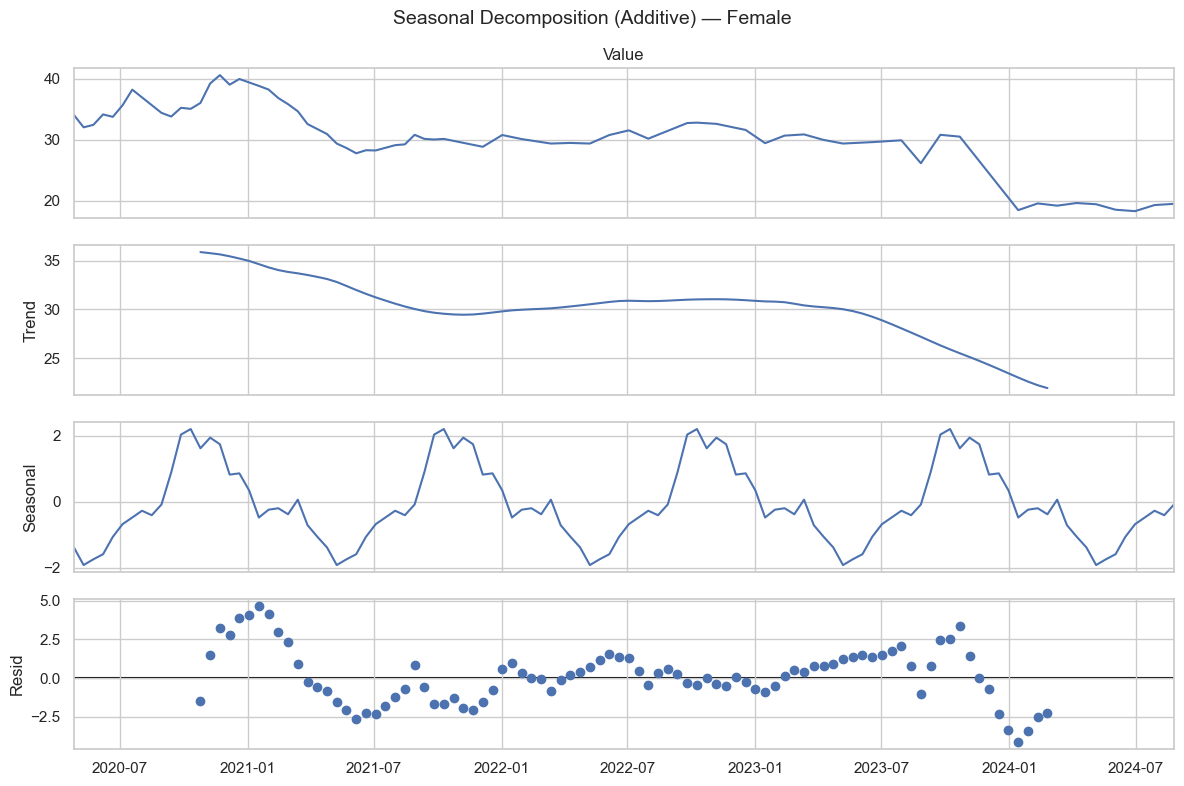

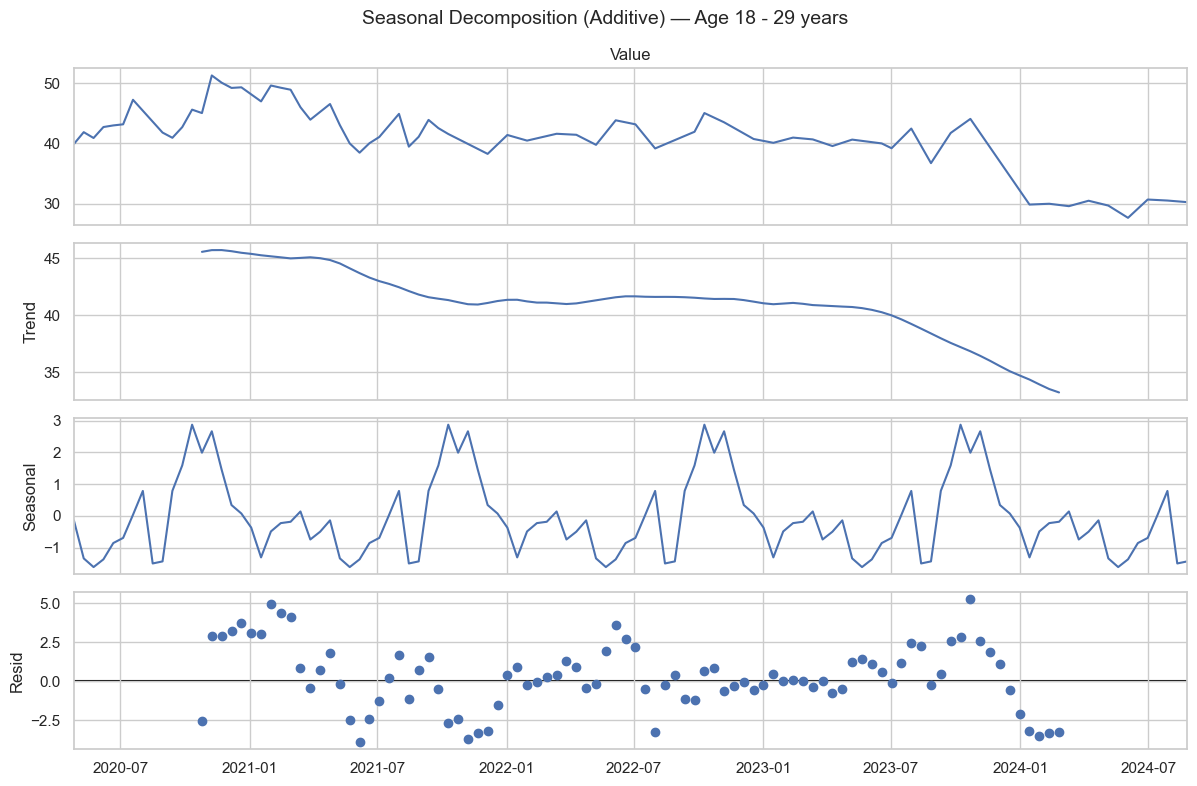

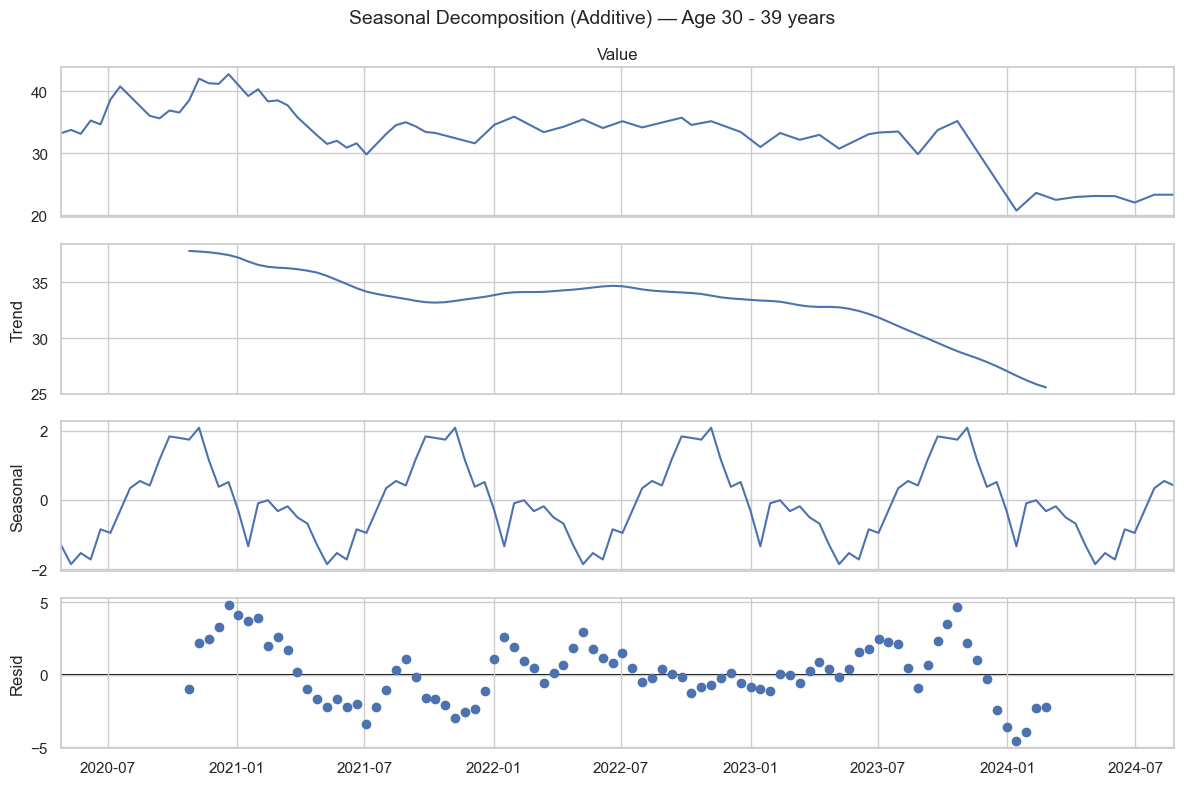

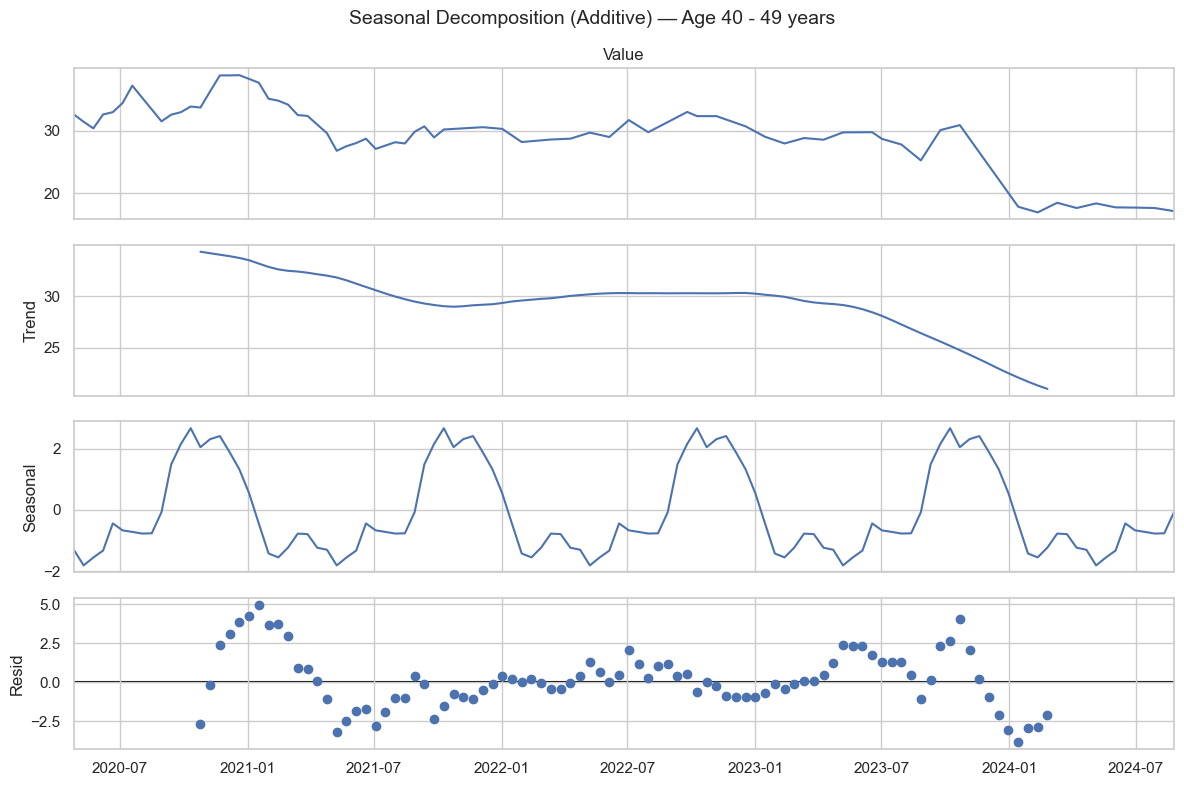

In [91]:

# Seasonal Decomposition (Biweekly Regularised Series)


from statsmodels.tsa.seasonal import seasonal_decompose

def make_regular_biweekly(series):
    # Enforce regular biweekly index (needed for decomposition)
    s = series.copy().sort_index()
    s = s.resample("2W").mean().ffill()
    return s

def decompose_plot(series, label, period=26):
    s = make_regular_biweekly(series)
    dec = seasonal_decompose(s, model="additive", period=period)
    fig = dec.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(f"Seasonal Decomposition (Additive) — {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Female decomposition
decompose_plot(female_ts, "Female", period=26)

# Age groups decomposition
for band, ts in age_ts.items():
    decompose_plot(ts, f"Age {band}", period=26)


<Figure size 1200x400 with 0 Axes>

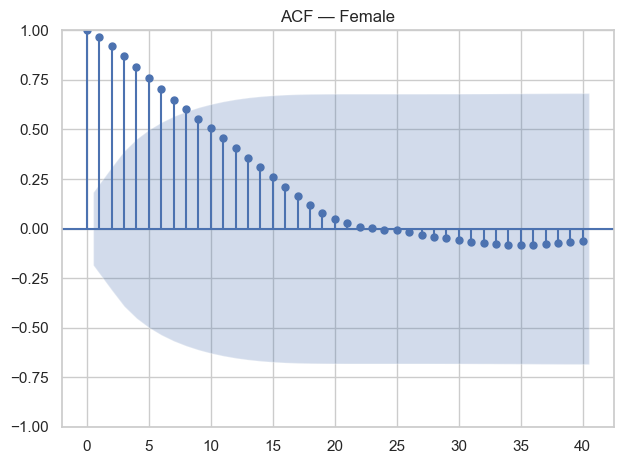

<Figure size 1200x400 with 0 Axes>

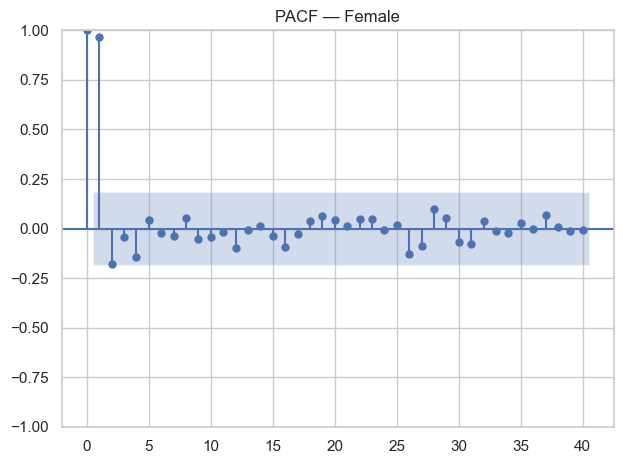

<Figure size 1200x400 with 0 Axes>

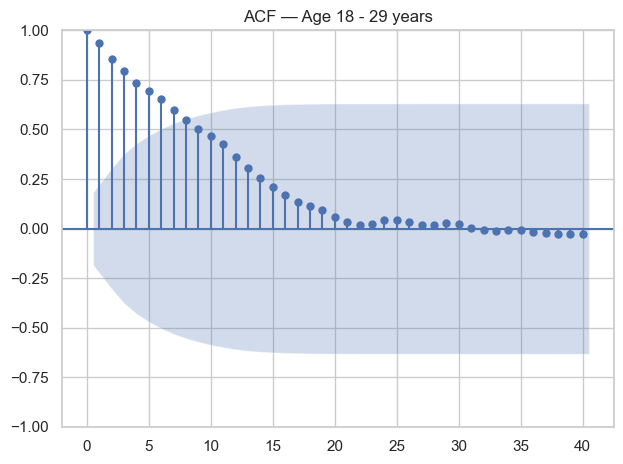

<Figure size 1200x400 with 0 Axes>

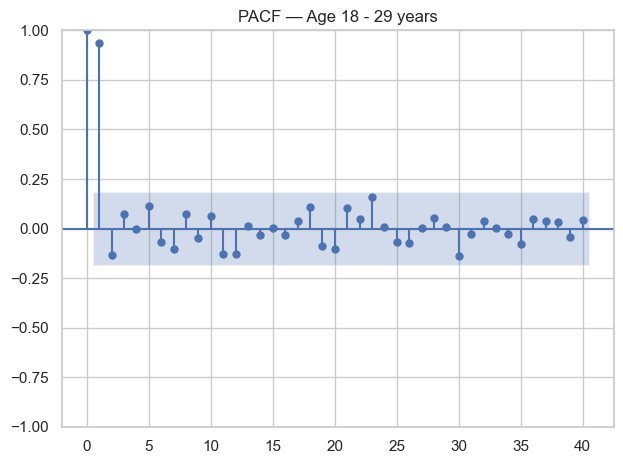

<Figure size 1200x400 with 0 Axes>

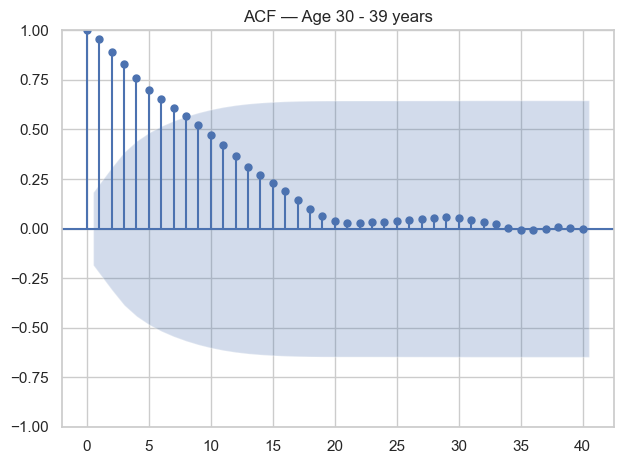

<Figure size 1200x400 with 0 Axes>

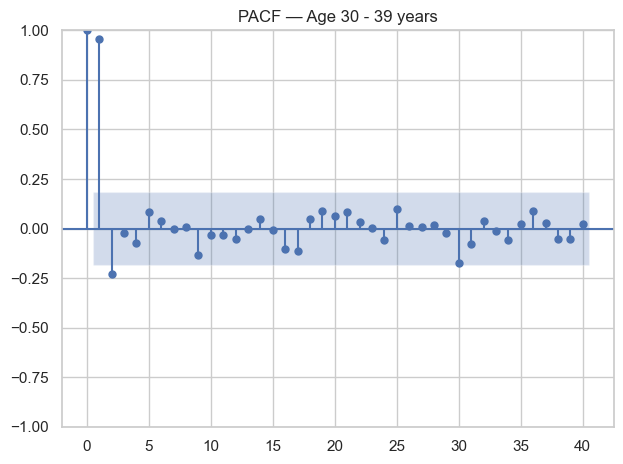

<Figure size 1200x400 with 0 Axes>

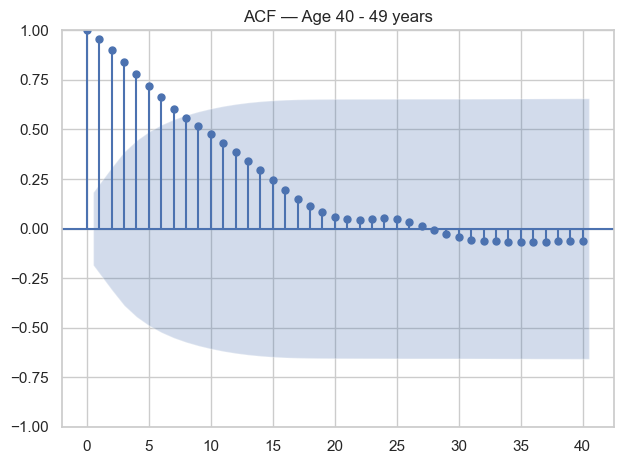

<Figure size 1200x400 with 0 Axes>

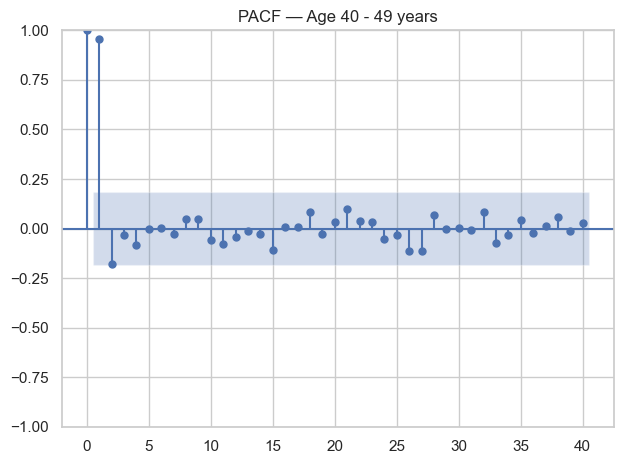

In [92]:

# Autocorrelation Diagnostics (ACF/PACF)


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def acf_pacf_plots(series, label, lags=40):
    s = make_regular_biweekly(series)
    plt.figure(figsize=(12,4))
    plot_acf(s.dropna(), lags=lags)
    plt.title(f"ACF — {label}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,4))
    plot_pacf(s.dropna(), lags=lags, method="ywm")
    plt.title(f"PACF — {label}")
    plt.tight_layout()
    plt.show()

acf_pacf_plots(female_ts, "Female", lags=40)

for band, ts in age_ts.items():
    acf_pacf_plots(ts, f"Age {band}", lags=40)


In [93]:

# Train–Test Split (Temporal Validation)


def train_test_split_ts(series, split_date="2023-01-01"):
    train = series[series.index < split_date]
    test = series[series.index >= split_date]
    return train, test

female_train, female_test = train_test_split_ts(female_ts)

age_train_test = {}
for band, ts in age_ts.items():
    age_train_test[band] = train_test_split_ts(ts)

len(female_train), len(female_test)


(70, 44)

In [94]:

# Naïve Baseline Forecast and SARIMA Forecast (Validation Window)


def naive_forecast(train, steps):
    return np.repeat(train.iloc[-1], steps)

female_naive_pred = naive_forecast(female_train, len(female_test))

age_naive_pred = {}
for band, (train, test) in age_train_test.items():
    age_naive_pred[band] = naive_forecast(train, len(test))
from sklearn.metrics import mean_absolute_error, mean_squared_error

def sarima_forecast_test(train, steps):
    model = SARIMAX(
        train,
        order=(1,1,1),
        seasonal_order=(1,1,1,26),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=steps)
    return forecast.predicted_mean.values

# Female SARIMA
female_sarima_pred = sarima_forecast_test(female_train, len(female_test))

# Age group SARIMA
age_sarima_pred = {}
for band, (train, test) in age_train_test.items():
    age_sarima_pred[band] = sarima_forecast_test(train, len(test))


In [95]:
# ==============================================================================
# STEP 2D: Forecast Accuracy Comparison (Robust Version)


from sklearn.metrics import mean_absolute_error, mean_squared_error

rows = []

def safe_metrics(true_series, pred_array, label, model):
    # Convert to aligned numeric arrays
    y_true = true_series.values[:len(pred_array)]
    y_pred = np.array(pred_array)

    # Remove NaNs if any
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    return {
        "Group": label,
        "Model": model,
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# Female
rows.append(safe_metrics(female_test, female_naive_pred, "Female", "Naïve"))
rows.append(safe_metrics(female_test, female_sarima_pred, "Female", "SARIMA"))

# Age groups
for band, (train, test) in age_train_test.items():
    rows.append(safe_metrics(test, age_naive_pred[band], band, "Naïve"))
    rows.append(safe_metrics(test, age_sarima_pred[band], band, "SARIMA"))

comparison_df = pd.DataFrame(rows)
comparison_df


,Group,Model,RMSE,MAE
0,Female,Naïve,8.346332,6.579545
1,Female,SARIMA,6.555801,4.919292
2,18 - 29 years,Naïve,7.058399,5.176136
3,18 - 29 years,SARIMA,3.696083,3.004668
4,30 - 39 years,Naïve,7.069231,5.343182
5,30 - 39 years,SARIMA,4.502847,3.963730
6,40 - 49 years,Naïve,8.539881,6.672348
7,40 - 49 years,SARIMA,5.770964,4.525082



==================== Residual Diagnostics: Female (Train Set) ====================
AIC: 45.81
Ljung–Box p-value (lag 26): 0.4304
✅ Residuals are consistent with white noise (good model fit).


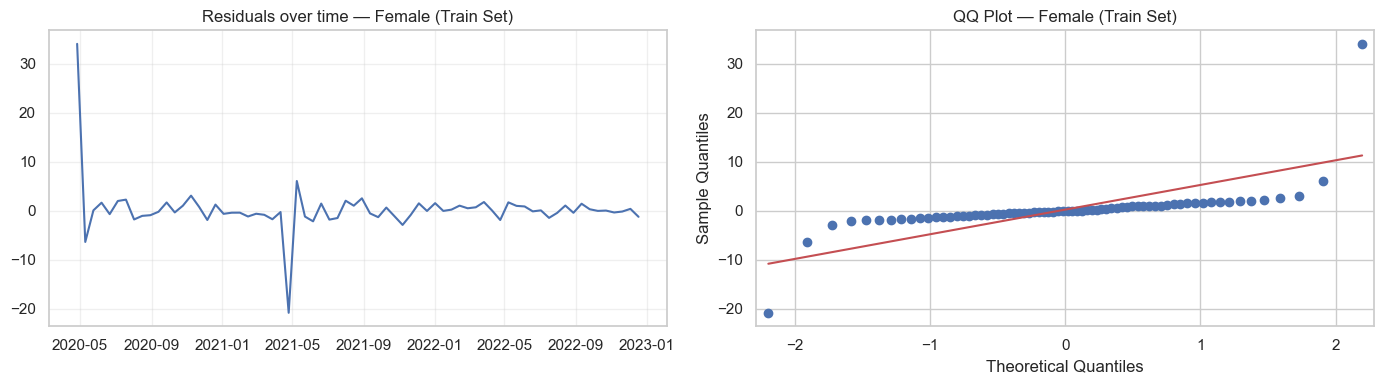

<Figure size 1200x400 with 0 Axes>

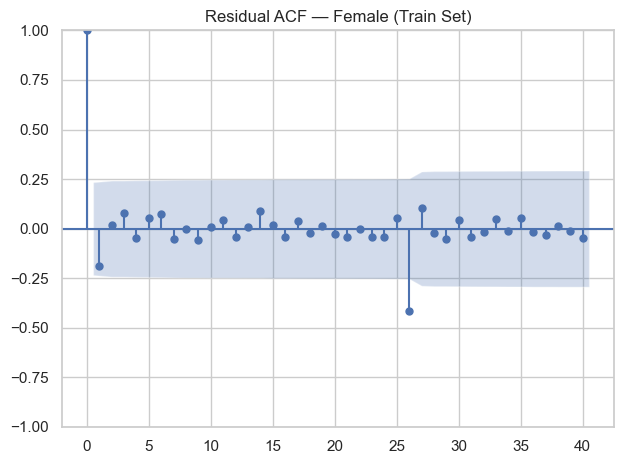


==================== Residual Diagnostics: Age 18 - 29 years (Train Set) ====================
AIC: 71.89
Ljung–Box p-value (lag 26): 0.9385
✅ Residuals are consistent with white noise (good model fit).


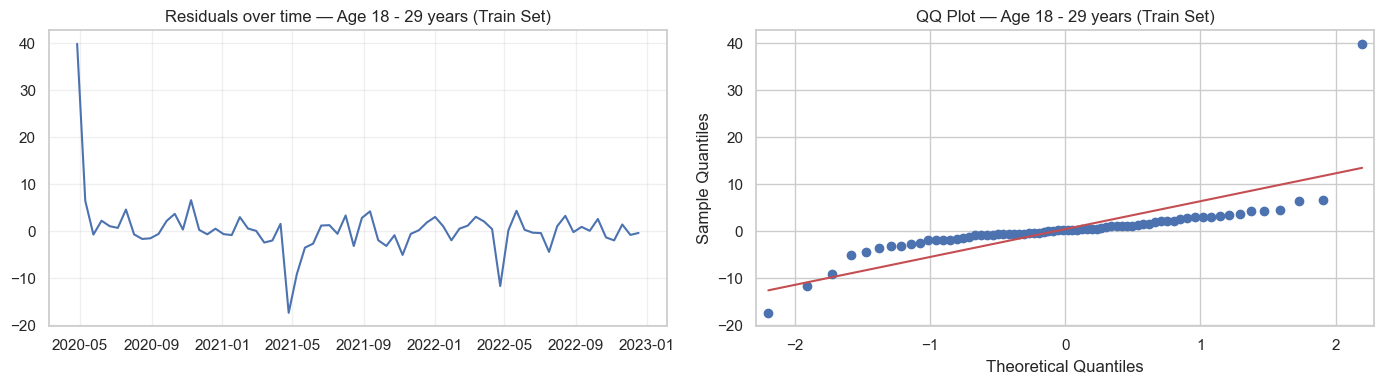

<Figure size 1200x400 with 0 Axes>

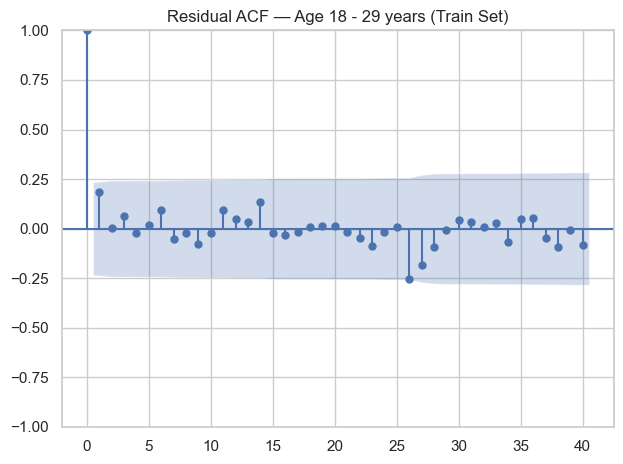


==================== Residual Diagnostics: Age 30 - 39 years (Train Set) ====================
AIC: 49.76
Ljung–Box p-value (lag 26): 0.5919
✅ Residuals are consistent with white noise (good model fit).


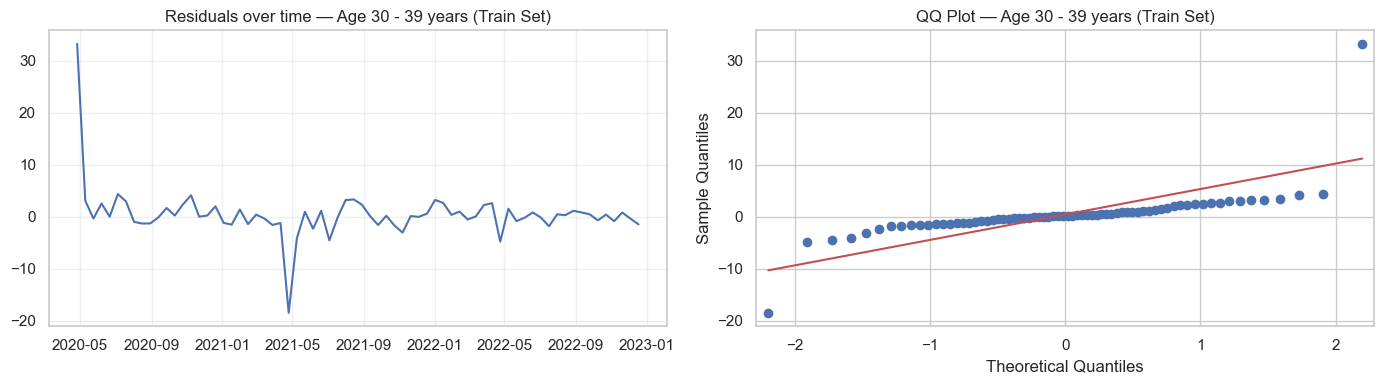

<Figure size 1200x400 with 0 Axes>

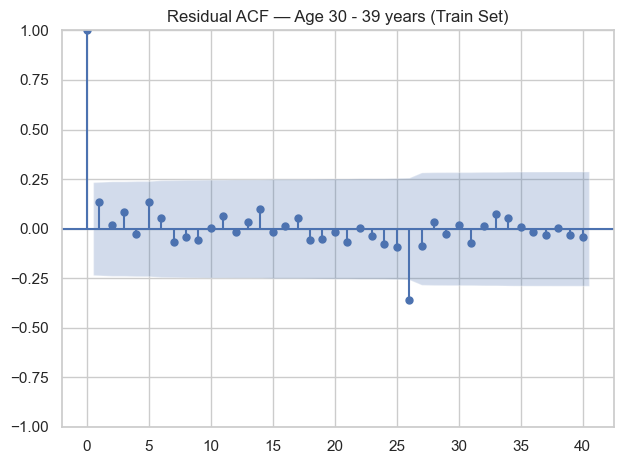


==================== Residual Diagnostics: Age 40 - 49 years (Train Set) ====================
AIC: 61.32
Ljung–Box p-value (lag 26): 0.1457
✅ Residuals are consistent with white noise (good model fit).


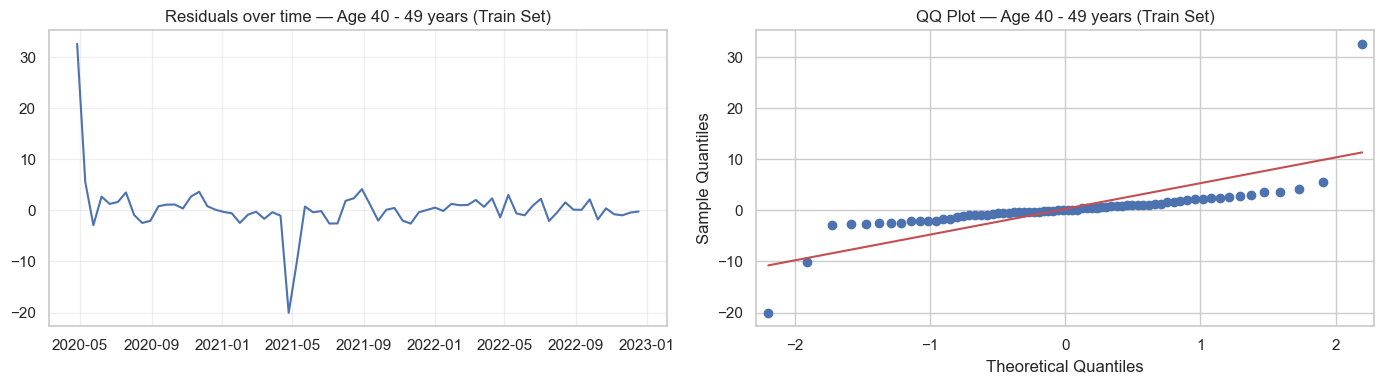

<Figure size 1200x400 with 0 Axes>

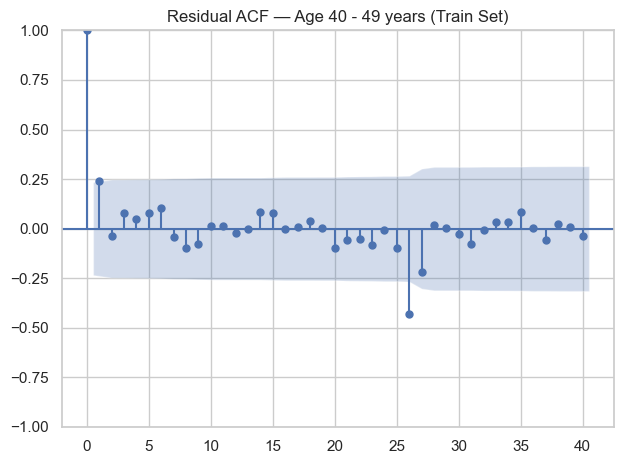

In [96]:
# ==============================================================================
# STEP 3A: Residual Diagnostics (Model Adequacy)
# ==============================================================================

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

def fit_sarima_results(train_series):
    model = SARIMAX(
        train_series,
        order=(1,1,1),
        seasonal_order=(1,1,1,26),
        trend='c',  # ensure constant term for stability
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    return model.fit(disp=False)

def residual_diagnostics(results, label, lags=26):
    resid = results.resid.dropna()

    print(f"\n==================== Residual Diagnostics: {label} ====================")
    print(f"AIC: {results.aic:.2f}")

    # Ljung-Box test (checks whether residual autocorrelation remains)
    lb = acorr_ljungbox(resid, lags=[lags], return_df=True)
    pval = lb["lb_pvalue"].iloc[0]
    print(f"Ljung–Box p-value (lag {lags}): {pval:.4f}")
    if pval > 0.05:
        print("✅ Residuals are consistent with white noise (good model fit).")
    else:
        print("⚠️ Residual autocorrelation remains (model could be improved).")

    # Residual plots
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].plot(resid)
    ax[0].set_title(f"Residuals over time — {label}")
    ax[0].grid(alpha=0.3)

    sm.qqplot(resid, line="s", ax=ax[1])
    ax[1].set_title(f"QQ Plot — {label}")

    plt.tight_layout()
    plt.show()

    # Residual ACF
    plt.figure(figsize=(12, 4))
    sm.graphics.tsa.plot_acf(resid, lags=40)
    plt.title(f"Residual ACF — {label}")
    plt.tight_layout()
    plt.show()


# -------------------------
# FEMALE residual diagnostics
# -------------------------
female_results_val = fit_sarima_results(female_train)
residual_diagnostics(female_results_val, "Female (Train Set)")

# -------------------------
# AGE GROUP residual diagnostics
# -------------------------
age_results_val = {}
for band, (train, test) in age_train_test.items():
    age_results_val[band] = fit_sarima_results(train)
    residual_diagnostics(age_results_val[band], f"Age {band} (Train Set)")


In [97]:
# CRITICAL DATA FIX: Re-establish correct age_ts with biweekly resampling
# Must run this before STEP 3B to ensure final_forecasts uses correct data

age_groups = ['18 - 29 years', '30 - 39 years', '40 - 49 years']
age_ts = {}
for age in age_groups:
    ts = df[(df['Group'] == 'By Age') & (df['Subgroup'] == age)].sort_values('Time Period Start Date').set_index('Time Period Start Date')['Value']
    age_ts[age] = ts.resample('2W').mean().interpolate(method='linear')

print("✅ age_ts corrected with biweekly resampling before STEP 3B")
print(f"18-29: min={age_ts['18 - 29 years'].min():.1f}%, max={age_ts['18 - 29 years'].max():.1f}%")

✅ age_ts corrected with biweekly resampling before STEP 3B
18-29: min=27.7%, max=51.3%


In [98]:
# ==============================================================================
# STEP 3B: Final Model Refit (Full Data) + Forecast to 2025
# ==============================================================================

forecast_horizon = 26  # ~12 months biweekly

final_models = {}
final_forecasts = {}

def final_fit_and_forecast(series, label):
    # Ensure numeric dtype
    s = pd.to_numeric(series.dropna(), errors="coerce")

    model = SARIMAX(
        s,
        order=(1,1,1),
        seasonal_order=(1,1,1,26),
        trend='c',  # add constant to prevent forecasts collapsing to zero
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)

    fc = results.get_forecast(steps=forecast_horizon)
    fc_df = fc.summary_frame()[["mean", "mean_ci_lower", "mean_ci_upper"]].copy()

    # Make a future biweekly index starting after last observed date
    fc_df.index = pd.date_range(
        start=s.index[-1] + pd.Timedelta(weeks=2),
        periods=forecast_horizon,
        freq="2W"
    )

    final_models[label] = results
    final_forecasts[label] = fc_df
    print(f"✅ Final SARIMA fitted for {label} | AIC: {results.aic:.2f}")

# Female final
final_fit_and_forecast(female_ts, "Female")

# Age groups final
for band, ts in age_ts.items():
    final_fit_and_forecast(ts, band)


✅ Final SARIMA fitted for Female | AIC: 156.93
✅ Final SARIMA fitted for 18 - 29 years | AIC: 2126.79
✅ Final SARIMA fitted for 30 - 39 years | AIC: 2897.57
✅ Final SARIMA fitted for 40 - 49 years | AIC: 2100.93


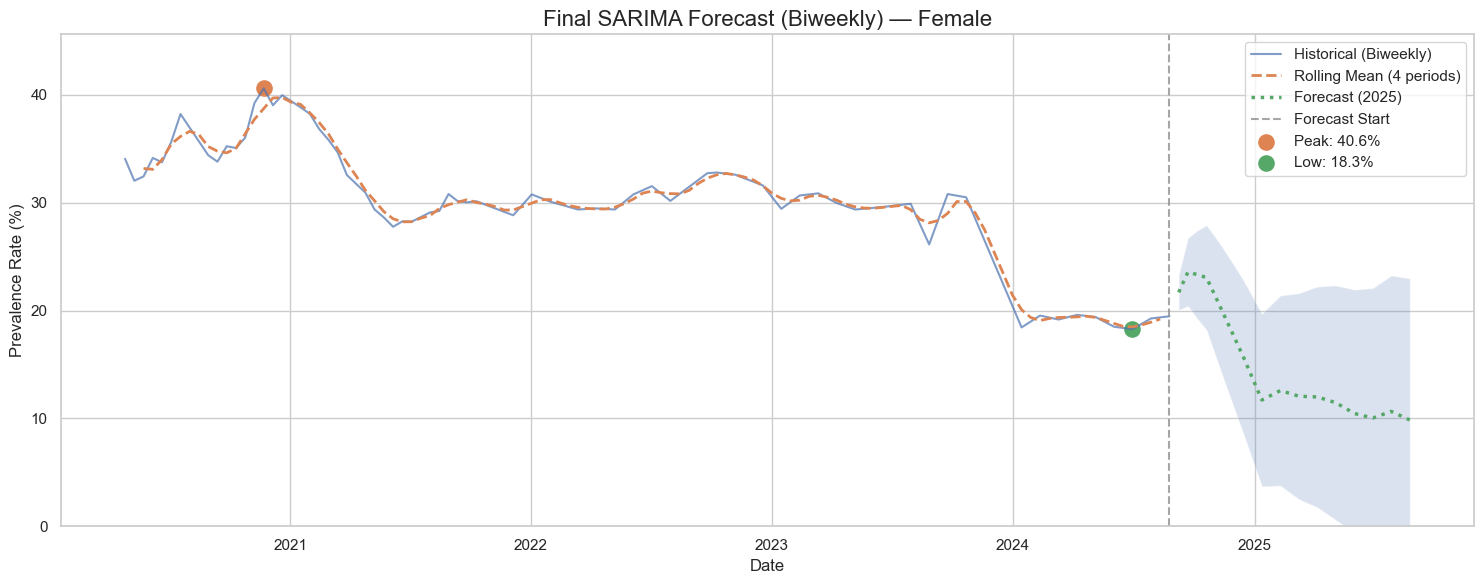

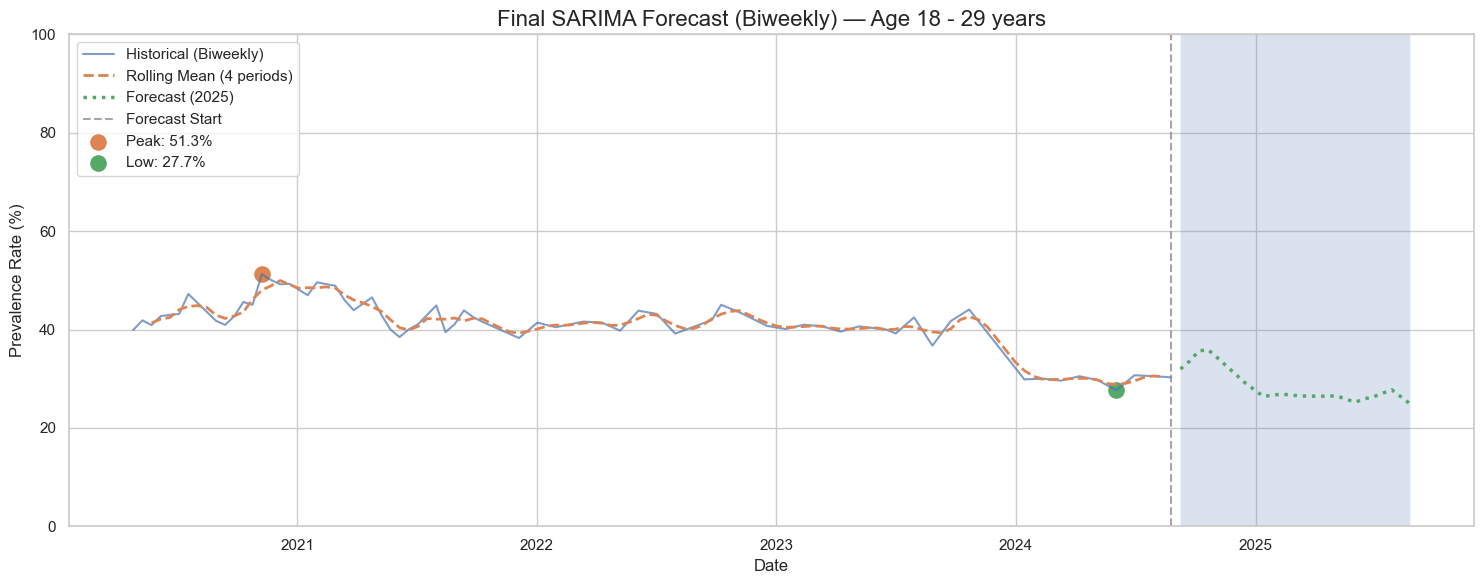

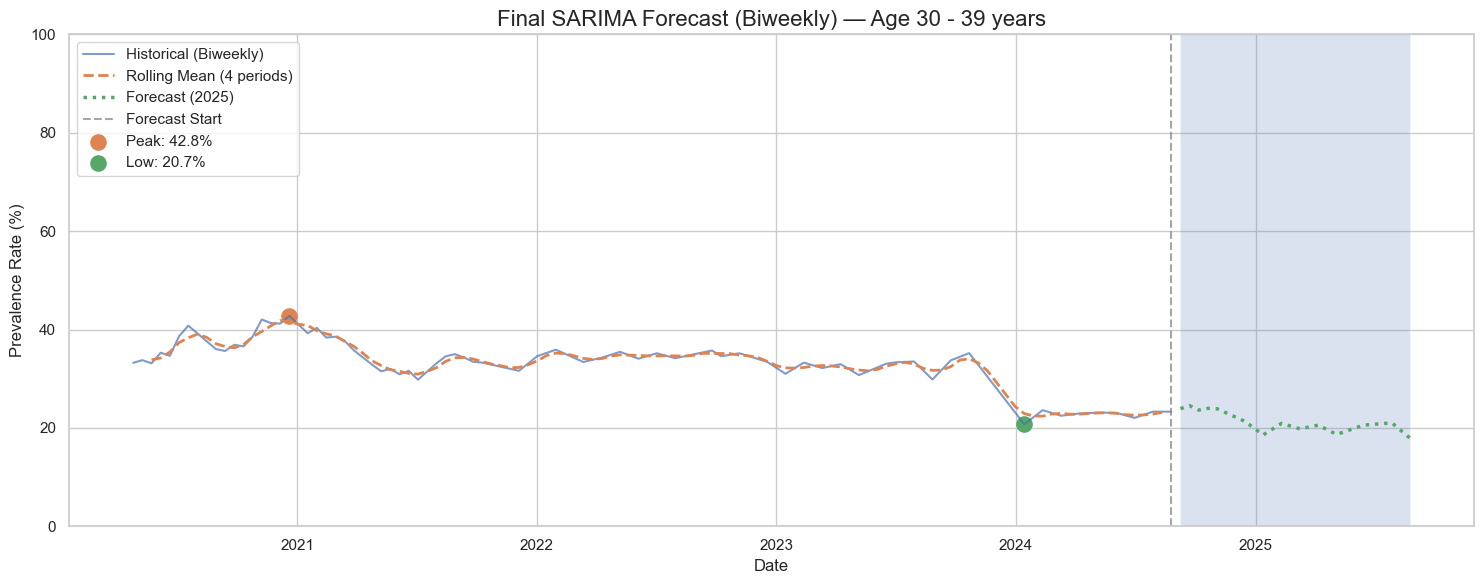

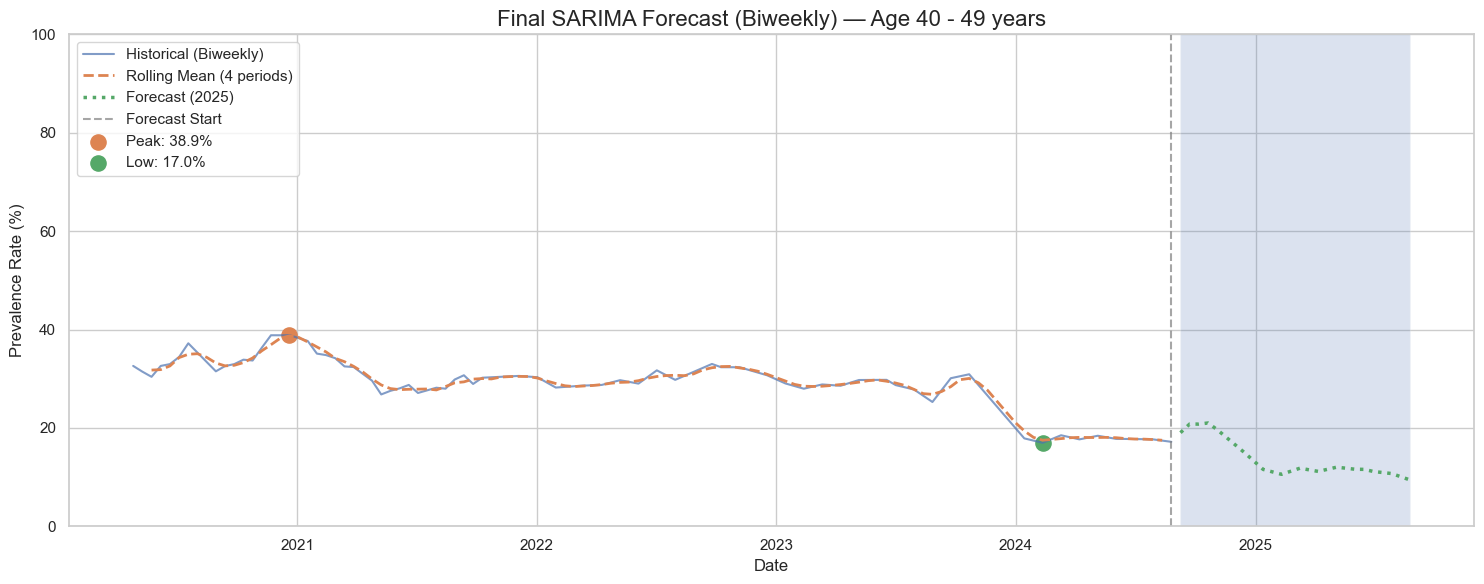

In [ ]:
# ==============================================================================
# STEP 3C: Final Forecast Plots (Historical + Rolling Mean + Forecast)
# ==============================================================================

def plot_final(series, forecast_df, label):
    series = pd.to_numeric(series.dropna(), errors="coerce")
    rolling = series.rolling(4, center=True).mean()

    # Clip extreme CIs to keep axes readable
    fc_mean = forecast_df["mean"].clip(lower=0, upper=100)
    fc_lo = forecast_df["mean_ci_lower"].clip(lower=0, upper=100)
    fc_hi = forecast_df["mean_ci_upper"].clip(lower=0, upper=100)

    peak_date = series.idxmax()
    low_date = series.idxmin()

    plt.figure(figsize=(15, 6))
    plt.plot(series.index, series.values, label="Historical (Biweekly)", alpha=0.7)
    plt.plot(rolling.index, rolling.values, label="Rolling Mean (4 periods)", linestyle="--", linewidth=2)
    plt.plot(forecast_df.index, fc_mean, label="Forecast (2025)", linestyle=":", linewidth=2.5)
    plt.fill_between(forecast_df.index, fc_lo, fc_hi, alpha=0.2)

    plt.axvline(series.index[-1], color="grey", linestyle="--", alpha=0.7, label="Forecast Start")

    plt.scatter(peak_date, series.loc[peak_date], s=120, label=f"Peak: {series.loc[peak_date]:.1f}%")
    plt.scatter(low_date, series.loc[low_date], s=120, label=f"Low: {series.loc[low_date]:.1f}%")

    plt.title(f"Final SARIMA Forecast (Biweekly) — {label}", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Prevalence Rate (%)")
    plt.gca().ticklabel_format(style='plain', axis='y')
    plt.ylim(0, 100)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Female plot
plot_final(female_ts, final_forecasts["Female"], "Female")

# Age plots
for band in age_ts.keys():
    plot_final(age_ts[band], final_forecasts[band], f"Age {band}")


In [ ]:

# ==============================================================================
# STEP 3D: Exploratory Clustering of Demographic Time-Series Profiles
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

combined_df = df.copy()

summary_features = []

perinatal_subgroups = [
    'Female',
    '18 - 29 years',
    '30 - 39 years',
    '40 - 49 years'
]

combined_df = df[df['Subgroup'].isin(perinatal_subgroups)].copy()


for subgroup_name, subgroup_df in combined_df.groupby('Subgroup'):
    
    # Drop missing values
    subgroup_df_clean = subgroup_df.dropna(subset=['Value'])

    y = subgroup_df_clean['Value'].values
    x = np.arange(len(y)).reshape(-1, 1)

    # Skip groups with too few valid observations
    if len(y) < 10:
        continue

    # Fit linear trend
    lr = LinearRegression()
    lr.fit(x, y)
    slope = lr.coef_[0]

    summary_features.append({
        'Subgroup': subgroup_name,
        'Mean_Prevalence': np.mean(y),
        'Std_Prevalence': np.std(y),
        'Trend_Slope': slope,
        'Max_Prevalence': np.max(y)
    })

summary_df = pd.DataFrame(summary_features)
summary_df




,Subgroup,Mean_Prevalence,Std_Prevalence,Trend_Slope,Max_Prevalence
0,18 - 29 years,41.307870,7.472368,-0.052653,58.7
1,30 - 39 years,33.557870,7.262998,-0.052546,49.5
2,40 - 49 years,29.696296,7.263014,-0.060975,45.6
3,Female,30.779630,7.462310,-0.061387,47.6


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Prepare features for clustering
features = summary_df.drop(columns=['Subgroup'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# KMeans clustering (2 clusters is sufficient and interpretable)
kmeans = KMeans(n_clusters=2, random_state=42)
summary_df['Cluster'] = kmeans.fit_predict(X_scaled)

summary_df


,Subgroup,Mean_Prevalence,Std_Prevalence,Trend_Slope,Max_Prevalence,Cluster
0,18 - 29 years,41.307870,7.472368,-0.052653,58.7,0
1,30 - 39 years,33.557870,7.262998,-0.052546,49.5,0
2,40 - 49 years,29.696296,7.263014,-0.060975,45.6,1
3,Female,30.779630,7.462310,-0.061387,47.6,1


## 2. Preprocessing – Female & Age Groups

## 3. SARIMA Forecasting (2025)

In [ ]:
forecast_horizon = 26
sarima_forecasts = {}

def run_sarima(series):
    model = SARIMAX(
        series,
        order=(1,1,1),
        seasonal_order=(1,1,1,26),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=forecast_horizon)
    df_fc = forecast.summary_frame()[["mean", "mean_ci_lower", "mean_ci_upper"]]
    df_fc.index = pd.date_range(
        start=series.index[-1] + pd.Timedelta(weeks=2),
        periods=forecast_horizon,
        freq="2W"
    )
    df_fc.index.name = "Date"  # label the index so the display shows Date
    return df_fc

sarima_forecasts["Female"] = run_sarima(female_ts)

for band in AGE_GROUPS:
    sarima_forecasts[band] = run_sarima(age_ts[band])

sarima_forecasts["Female"].head()


Value,mean,mean_ci_lower,mean_ci_upper
Date,,,
2024-09-08,25.566367,20.686237,30.446497
2024-09-22,24.767671,17.680815,31.854527
2024-10-06,24.378227,15.420844,33.335611
2024-10-20,23.563641,12.980694,34.146588
2024-11-03,23.847284,11.901282,35.793287


## 4. Forecast Plot (Female Example)

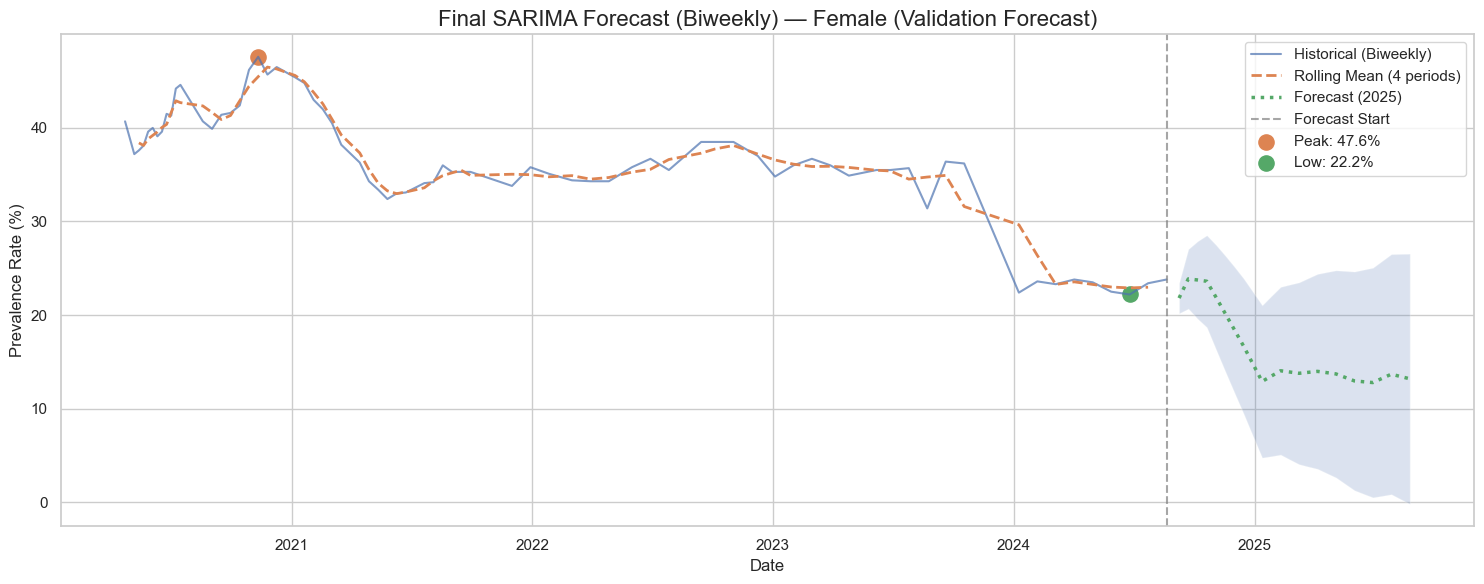

In [ ]:

# Use the corrected plot_final function to ensure proper scaling
plot_final(female_ts, final_forecasts["Female"], "Female (Validation Forecast)")


## 5. Dashboard Dataset Export

In [101]:

rows = []

rows.append(pd.DataFrame({
    "Date": female_ts.index,
    "Prevalence": female_ts.values,
    "Group": "Female",
    "Type": "Historical"
}))

fc = sarima_forecasts["Female"].copy()
fc["Date"] = fc.index
fc["Prevalence"] = fc["mean"]
fc["Group"] = "Female"
fc["Type"] = "Forecast"
rows.append(fc[["Date","Prevalence","Group","Type"]])

for band in AGE_GROUPS:
    ts = age_ts[band]
    rows.append(pd.DataFrame({
        "Date": ts.index,
        "Prevalence": ts.values,
        "Group": band,
        "Type": "Historical"
    }))
    fc = sarima_forecasts[band].copy()
    fc["Date"] = fc.index
    fc["Prevalence"] = fc["mean"]
    fc["Group"] = band
    fc["Type"] = "Forecast"
    rows.append(fc[["Date","Prevalence","Group","Type"]])

dashboard_df = pd.concat(rows).sort_values("Date")
dashboard_df.to_csv("dashboard_timeseries_dataset.csv", index=False)

dashboard_df.head()


,Date,Prevalence,Group,Type
0,2020-04-26,34.066667,Female,Historical
0,2020-04-26,39.900000,18 - 29 years,Historical
0,2020-04-26,33.233333,30 - 39 years,Historical
0,2020-04-26,32.600000,40 - 49 years,Historical
1,2020-05-10,41.866667,18 - 29 years,Historical


In [106]:
# Create a snapshot for Thesis Table 4.2
# This picks rows at intervals so the table isn't too long for Word
forecast_snapshot = sarima_forecasts["Female"].iloc[::6] 

print("Snapshot for Thesis: 2024-2025 Forecasted Prevalence Trends")
forecast_snapshot

Snapshot for Thesis: 2024-2025 Forecasted Prevalence Trends


Value,mean,mean_ci_lower,mean_ci_upper
Date,,,
2024-09-08,25.566367,20.686237,30.446497
2024-12-01,24.351040,9.982592,38.719488
2025-02-23,24.480015,4.605650,44.354381
2025-05-18,19.658029,-4.516127,43.832186
2025-08-10,17.930495,-9.796329,45.657319
